# 导包与数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn import cluster
from sklearn import manifold 
from sklearn import metrics

from scipy.stats import norm
from  scipy import stats
from scipy.stats import pearsonr

# 画漏斗图
from pyecharts import options as opts
from pyecharts.charts import Funnel

#  解决汉字显示不出来的问题（设置为楷体）
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['KaiTi']

In [2]:
info = pd.read_csv("user_info_format1.csv") # 用户信息表

In [3]:
log = pd.read_csv("user_log_format1.csv") # 用户行为表

# 数据说明

本项目的数据来源于阿里天池平台。数据来源官网：https://tianchi.aliyun.com/dataset/dataDetail?dataId=42


本项目的数据记录了2015年05月11日-2015年11月11日期间每一天每一个淘宝用户的**行为**（点击，收藏，加购，购买），以及这些用户的具体**信息**（性别，年龄）.


本项目共使用了两个表"user_info_format1.csv"(约42万行数据)与"user_log_format1.csv"(约5千万行数据)，每个表字段的具体说明参见数据来源官网或"README.md".

In [4]:
info

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0
...,...,...,...
424165,395814,3.0,1.0
424166,245950,0.0,1.0
424167,208016,NaN,NaN
424168,272535,6.0,1.0


In [5]:
log

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0
...,...,...,...,...,...,...,...
54925325,208016,107662,898,1346,7995.0,1110,0
54925326,208016,1058313,898,1346,7995.0,1110,0
54925327,208016,449814,898,983,7995.0,1110,0
54925328,208016,634856,898,1346,7995.0,1110,0


In [6]:
print(log.shape[0]) #查看行数
print(log.shape[1]) # 查看列数
print(log.dtypes) # 查看数据类型

54925330
7
user_id          int64
item_id          int64
cat_id           int64
seller_id        int64
brand_id       float64
time_stamp       int64
action_type      int64
dtype: object


# 数据预处理

## 随机取样

log表的数据有五千多万条，跑起来资源管理器总是炸掉。无奈之下只好从log表中随机取样了。

具体做法：为了保证每个用户行为记录不减少太多，我们只从info表中取1%的用户（4242个用户）出来。然后根据这些用户再从log里选相应的用户。

In [7]:
info = info.sample(frac = 0.01) # 从info表中随机取1%
userid = info.user_id # 取出选出来的userid
log1 = log[log['user_id'].isin(userid)]#根据选出来的userid再从log表中筛选
log2 = log1.sort_values(by = 'user_id')
log2

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
46315020,36,255287,898,3716,7995.0,1110,0
46314991,36,107662,898,1346,7995.0,1111,0
46314992,36,634856,898,1346,7995.0,1111,0
46314993,36,634856,898,1346,7995.0,1111,2
46314994,36,574275,898,1903,7995.0,1111,0
...,...,...,...,...,...,...,...
39028133,424053,781936,598,426,5364.0,1111,0
39028134,424053,34460,1326,2113,3398.0,920,0
39028135,424053,1049364,1075,3365,7524.0,627,0
39028119,424053,1049364,1075,3365,7524.0,627,0


In [8]:
#仅取'user_id','time_stamp','action_type'列的数据
log3 = log2[['user_id','time_stamp','action_type']]
#再检查各列有无缺失值
log3.isnull().any()

user_id        False
time_stamp     False
action_type    False
dtype: bool

## 处理时间数据

目前的时间数据是int型的，且只有月份与日期。我们需要加上年份，并且转换为datetime类型。

In [9]:
time_stamp = log3['time_stamp'].astype(str) # 先转化为str型
time_stamp1 = '2015' + time_stamp  #增加年份
time_stamp2 = pd.to_datetime(time_stamp1,format='%Y%m%d') #转换为datetime
log3['time_stamp'] = time_stamp2
log3.sort_values(by = 'time_stamp',inplace = True)
log3 = log3[log3['time_stamp'] != '2015-11-12']# 2015-11-12是一个脏数据，去掉
log3

<ipython-input-9-8a844b80967c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log3['time_stamp'] = time_stamp2
<ipython-input-9-8a844b80967c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log3.sort_values(by = 'time_stamp',inplace = True)


,user_id,time_stamp,action_type
36117974,236323,2015-05-11,2
8572986,76031,2015-05-11,3
11559489,385550,2015-05-11,2
51590391,90867,2015-05-11,2
34824865,360108,2015-05-11,3
...,...,...,...
22598632,216078,2015-11-11,0
22598608,216078,2015-11-11,0
22598605,216078,2015-11-11,0
22598606,216078,2015-11-11,0


# 解释性数据分析(EDA)

## 时间维度对PV,UV进行分析

- pv值:淘宝每天的访问量（包含同一用户的重复访问）
- uv值:淘宝每天的访问人数（一个用户的访问只记录一次）

In [10]:
pv = log3.groupby('time_stamp')['user_id'].count()
uv = log3.groupby('time_stamp')['user_id'].nunique()

Text(0, 0.5, 'UV')

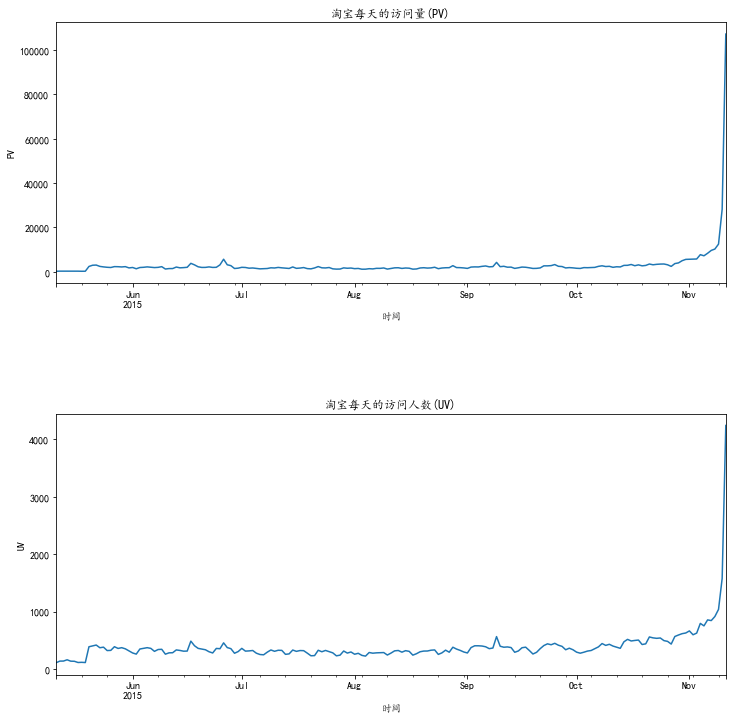

In [11]:
fig,axes = plt.subplots(nrows = 2,ncols = 1,figsize = (12,12))
plt.subplots_adjust(hspace = 0.5)# 调整上下两个子图的间距

pv.plot(ax = axes[0])
uv.plot(ax = axes[1])

axes[0].set_title('淘宝每天的访问量(PV)')
axes[0].set_xlabel('时间')
axes[0].set_ylabel('PV')

axes[1].set_title('淘宝每天的访问人数(UV)')
axes[1].set_xlabel('时间')
axes[1].set_ylabel('UV')

**结论:**
- PV,UV在平时呈现周期性的变化,在双11时候呈现断崖式增长.

## 用户行为分析

### 时间维度

In [12]:
# 首先拆解表，将action_type列转行
log4 = pd.pivot_table(log3,
              index = 'time_stamp',# 以time_stamp为行索引分组
              columns = 'action_type',# 根据action_type的不同分割每行的数据
              values = 'user_id',# 每行显示的该日期下的user_id（当每个日期有多个user_id时，默认显示user_id的平均值）
              aggfunc = np.size # 更改默认平均为求user_id的总数
              )
log4.columns = ["click","cart",'buy','fav']
log4

,click,cart,buy,fav
time_stamp,,,,
2015-05-11,NaN,NaN,100.0,78.0
2015-05-12,NaN,NaN,139.0,95.0
2015-05-13,NaN,3.0,134.0,101.0
2015-05-14,NaN,NaN,142.0,136.0
2015-05-15,NaN,2.0,109.0,129.0
...,...,...,...,...
2015-11-07,8775.0,31.0,129.0,653.0
2015-11-08,9261.0,46.0,113.0,791.0
2015-11-09,11392.0,49.0,130.0,867.0


Text(0.4, 0.9, '日维度的用户行为变化')

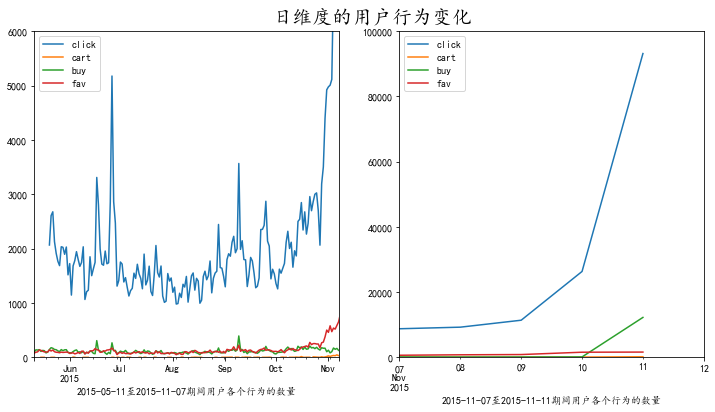

In [13]:
fig,axes = plt.subplots(nrows = 1,ncols = 2,figsize = (12,6))

log4.plot(ax = axes[0])
axes[0].set_ylim([0,6000])
axes[0].set_xlim(['2015-05-11','2015-11-07'])
axes[0].set_xlabel('2015-05-11至2015-11-07期间用户各个行为的数量')

log4.plot(ax = axes[1])
axes[1].set_ylim([0,100000])
axes[1].set_xlim(['2015-11-07','2015-11-12'])
axes[1].set_xlabel('2015-11-07至2015-11-11期间用户各个行为的数量')

fig.text(x=0.4, y=0.90,s='日维度的用户行为变化', fontsize=20)

**结论：**
- 11月9日之前四种行为呈周期性波动。“点击”行为远高于其他三种行为的数量.
- 11月9日开始用户的“点击行为”激增，推断这是因为用户提前一天开始为双十一挑选心仪的产品.
- 11月11日当天“点击行为”达到鼎盛时期，仅4242个用户，就产生了近十万次的点击行为。“购买”行为数量在双11当天也比平时翻了50倍之多.

### 行为转化漏斗

由于双11当天的行为转化比较特殊，会对整体的行为转化率有很大影响.

所以我们将日常时期与双11时期的用户行为转化分开讨论.

#### 日常期间行为转化漏斗

In [14]:
log5 = log3[log3['time_stamp'] <= '2015-11-05']
df = log5.groupby('action_type')['user_id'].count().reset_index().rename(columns={'user_id':'num'}).reindex([0,3,2]).reset_index(drop = True)
df# 计算出2015-05-11至2015-11-05期间”点击“，”收藏“，”购买“这三种行为的总量

,action_type,num
0,0,332990
1,3,23379
2,2,20668


In [15]:
# 单一转化率(错位相除)
t = np.array(df['num'])[:-1]
t1 = np.array(df['num'])[1:]
conv1 = list(t1 / t)# 转化成list
conv1.insert(0,1)# 第一位插入1
conv1 = [round(x*100,2) for x in conv1]
df['single_convert'] = conv1

# 总体转化率（都除第一个）
conv2 = df['num'] / df['num'][0]
conv2 = [round(x*100,2) for x in conv2]
df['all_convert'] = conv2

df

,action_type,num,single_convert,all_convert
0,0,332990,100.00,100.00
1,3,23379,7.02,7.02
2,2,20668,88.40,6.21


In [16]:
# 画图
atrr = ['浏览','收藏','购买']
value = (np.array(df['all_convert'])).tolist()
funnel = Funnel()# 实例化

#添加数据
funnel.add("淘宝",[list(z) for z in zip(atrr,value)])

#设置参数
funnel.set_global_opts(title_opts = opts.TitleOpts(title = '淘宝用户行为转化漏斗'))
funnel.set_series_opts(label_opts = opts.LabelOpts(formatter = '{b}:{c}'))

#画图
funnel.render_notebook()

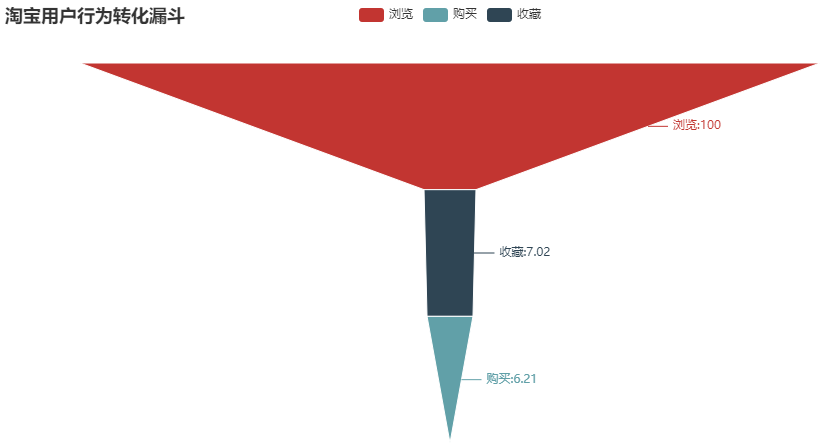

#### 双11期间用户行为转化漏斗

In [17]:
log6 = log3[log3['time_stamp'] > '2015-11-05']
df1 = log6.groupby('action_type')['user_id'].count().reset_index().rename(columns={'user_id':'num'})
df1# # 可以看到双十一期间用户大多点击后直接购买，少有加购或收藏行为，所以我们仅考虑”点击“到”购买“间的转化率

,action_type,num
0,0,156436
1,1,475
2,2,12926
3,3,6102


In [18]:
df1 = df1.reindex([0,2])
df1

,action_type,num
0,0,156436
2,2,12926


In [19]:
# 单一转化率(错位相除)
tt = np.array(df1['num'])[:-1]
tt1 = np.array(df1['num'])[1:]
cconv1 = list(tt1 / tt)# 转化成list
cconv1.insert(0,1)# 第一位插入1
cconv1 = [round(x*100,2) for x in cconv1]
df1['single_convert'] = cconv1

# 总体转化率（都除第一个）
cconv2 = df1['num'] / df1['num'][0]
cconv2 = [round(x*100,2) for x in cconv2]
df1['all_convert'] = cconv2

df1

,action_type,num,single_convert,all_convert
0,0,156436,100.00,100.00
2,2,12926,8.26,8.26


In [20]:
# 画图
atrr = ['浏览','购买']
value = (np.array(df1['all_convert'])).tolist()
funnel1 = Funnel()# 实例化

#添加数据
funnel1.add("淘宝",[list(z) for z in zip(atrr,value)])

#设置参数
funnel1.set_global_opts(title_opts = opts.TitleOpts(title = '双11期间淘宝用户行为转化漏斗'))
funnel1.set_series_opts(label_opts = opts.LabelOpts(formatter = '{b}:{c}'))

#画图
funnel1.render_notebook()

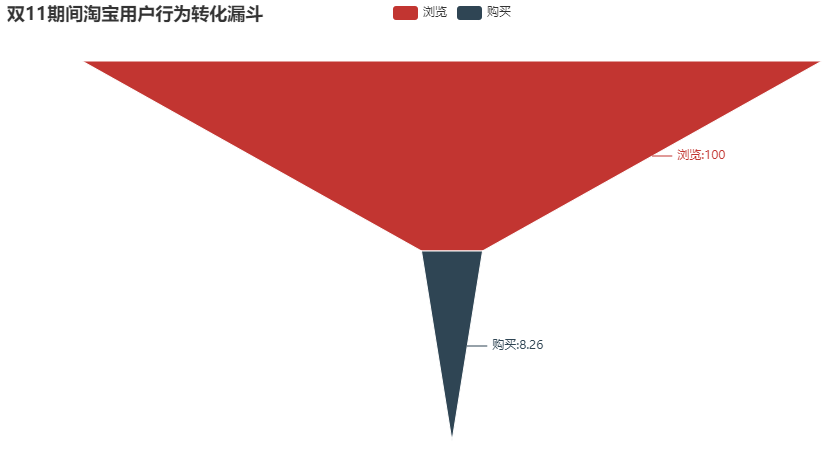

**结论：**

- 日常期间由浏览到收藏的转化率为7.3%、浏览到购买的转化率为6.0%.
- 双11期间浏览到购买的转化率为8.4%.

可以看到双11期间的转化率比平时高，但是没有高很多，也就是说双11浏览淘宝的用户虽然很多，但是真正有购买行为的用户比例却没有比平时高出很多。这说明：双十一的销售量激增的深层原因是双11这个噱头吸引来了巨大量的用户，而不是每个用户购买率层面上的增加。

### 用户维度

接下来我们对05-11至11-11这6个月的时间里，每个用户的总购买次数进行分析.

In [21]:
# 05-11至11-11
buy = log3[log3['action_type'] == 2].groupby('user_id').count()['action_type']
# (剔除双11)05-11至11-07
buy1 = log3[(log3['action_type'] == 2) & (log3['time_stamp'] <= '2015-11-07')].groupby('user_id').count()['action_type']

Text(0.5, 1.0, '6个月内(除去双11)用户的购买次数')

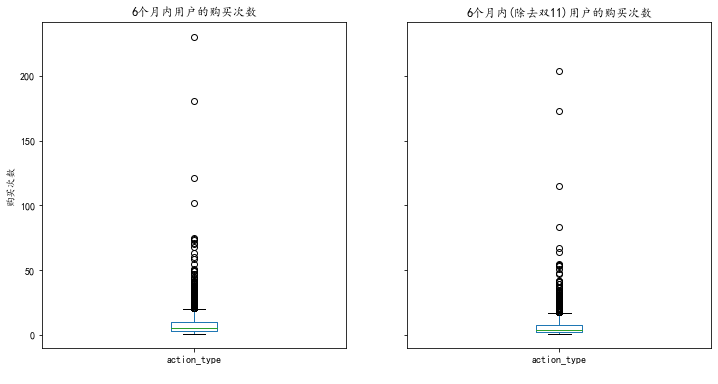

In [22]:
fig,axes = plt.subplots(nrows = 1,ncols = 2,sharey = True,figsize = (12,6))# 共用Y轴

buy.plot.box(ax = axes[0])
axes[0].set_xlabel(' ')
axes[0].set_ylabel('购买次数')
axes[0].set_title('6个月内用户的购买次数')

buy1.plot.box(ax = axes[1])
axes[1].set_xlabel(' ')
axes[1].set_ylabel('购买次数')
axes[1].set_title('6个月内(除去双11)用户的购买次数')

**结论：**
- 大部分的用户6个月以来的购物次数在7-8次左右，但也有不少的离群用户。引发了一个思考：这些离群用户是不是因为在双11买的特别多导致的呢？这些离群用户是平稳性地有优质的购物表现，还是仅在双11表现好呢？


- 为了回答上面的问题，我们观察剔除了双11的箱线图。发现图二中的离群用户没有显著变化。因此我们可以排除双11的因素，即这些离群用户在平时购买的就比普通用户多，而不是因为他们在双11买的多才造成了他们的购物总量多。因此，我们在制定营销策略时可以重点对待对这些购买次数很多且稳定的离群用户。

# 用户聚类

## 获取用户特征

为了将用户分为具有相似特征的几类，我们首先需要有一列列的用户特征数据。

在info表中我们已经有了用户的“性别”,“年龄”数据，为了让用户的特征维度覆盖面更广，我们考虑生成一个用户的“购物行为”特征。这就用到了RFM模型.

### 为用户新增RFM特征

这里要特别提醒的是：由于双11当天每个用户都有购买行为，所以我们不考虑双十一前后的购物记录.

RFM模型中由于我们没有M（消费金额）数据，所以我们仅仅考量F与R数据.

In [23]:
now = datetime(2015,11,6)

# 计算R（每个用户距离2015-11-06有多少天没购买过东西了）
R = log3[(log3['action_type'] == 2) & (log3['time_stamp'] <= '2015-11-05')].groupby('user_id')['time_stamp'].max().map(lambda x: now - x)
R = R.reset_index().rename(columns = {'time_stamp': 'Recency'})
R

,user_id,Recency
0,36,45 days
1,217,59 days
2,285,26 days
3,538,142 days
4,598,5 days
...,...,...
3375,423715,1 days
3376,423808,90 days
3377,423876,1 days
3378,423980,21 days


In [24]:
# # 计算F（每个用户的总购买次数）
F = log3[(log3['action_type'] == 2) & (log3['time_stamp'] <= '2015-11-05')].groupby('user_id').count()['time_stamp']
F = F.reset_index().rename(columns = {'time_stamp': 'Frequency'})
F

,user_id,Frequency
0,36,2
1,217,8
2,285,11
3,538,1
4,598,5
...,...,...
3375,423715,1
3376,423808,5
3377,423876,11
3378,423980,2


In [25]:
# 将R与F合并
RFM = pd.merge(R,F,on = 'user_id')
RFM['Recency'] = RFM['Recency'].astype('timedelta64[D]').astype(int)
RFM

,user_id,Recency,Frequency
0,36,45,2
1,217,59,8
2,285,26,11
3,538,142,1
4,598,5,5
...,...,...,...
3375,423715,1,1
3376,423808,90,5
3377,423876,1,11
3378,423980,21,2


In [26]:
np.percentile(RFM['Recency'], [25, 50, 75])# 四分位数求出划分点

array([12., 29., 70.])

In [27]:
np.percentile(RFM['Frequency'], [25, 50, 75])# 四分位数求出划分点

array([2., 4., 8.])

In [28]:
# 根据划分点为用户打分
def R(x):
    if x < 12:
        return 4
    elif (x >= 12) & (x < 28):
        return 3
    elif (x >= 28) & (x < 68):
        return 2
    elif (x >= 68):
        return 1

def F(x):
    if x < 2:
        return 1
    elif (x >= 2) & (x < 4):
        return 2
    elif (x >= 4) & (x < 8):
        return 3
    elif (x >= 8):
        return 4

In [29]:
RFM['R_score'] = RFM["Recency"].map(R)
RFM['F_score'] = RFM["Frequency"].map(F)

RFM总分值：RFM = R_score∗100 + F_score∗10 + M_score∗1 这是业内常用的打分方式.

这样一来，证明购买频率一直是商家比较看重的， 毕竟尽管你每次消费很少(M值小)，但你持续关注我们店铺且消费频率很高， 这样你迟早会中广告的招，累计消费迟早也很高.

由于我们没有M值，所以采取RFM = R_score∗10 + F_score的打分方式.

In [30]:
RFM['Total_score'] = RFM['R_score'] * 10 + RFM['F_score']
RFM

,user_id,Recency,Frequency,R_score,F_score,Total_score
0,36,45,2,2,2,22
1,217,59,8,2,4,24
2,285,26,11,3,4,34
3,538,142,1,1,1,11
4,598,5,5,4,3,43
...,...,...,...,...,...,...
3375,423715,1,1,4,1,41
3376,423808,90,5,1,3,13
3377,423876,1,11,4,4,44
3378,423980,21,2,3,2,32


### 特征表合并

In [31]:
data = pd.merge(info,RFM,on = 'user_id')[['user_id','gender','age_range','Total_score']]
data

,user_id,gender,age_range,Total_score
0,404724,2.0,3.0,44
1,247951,0.0,3.0,41
2,321246,0.0,3.0,14
3,364008,0.0,3.0,44
4,370359,1.0,0.0,42
...,...,...,...,...
3375,176676,0.0,0.0,44
3376,180510,0.0,4.0,23
3377,96992,2.0,2.0,21
3378,31574,0.0,0.0,11


In [32]:
# 查看每列缺失值
print(data.isnull().any())
# 去除缺失值
data = data[(data['gender'].notnull()) & (data['age_range'].notnull()) & (data['age_range'] != 0)]# 官方数据集上表示age=0也是缺失数据
# gender与age_range列类型转换
g = data['gender'].map(lambda x:int(x))
g = g.map(lambda x: 1 if x == 0 else 2)
a = data['age_range'].map(lambda x:int(x))
data['gender'] = g
data['age_range'] = a

data

user_id        False
gender          True
age_range       True
Total_score    False
dtype: bool


<ipython-input-32-505aebc0845d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gender'] = g
<ipython-input-32-505aebc0845d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['age_range'] = a


,user_id,gender,age_range,Total_score
0,404724,2,3,44
1,247951,1,3,41
2,321246,1,3,14
3,364008,1,3,44
5,38706,1,2,22
...,...,...,...,...
3371,122718,1,3,22
3374,208823,1,2,33
3376,180510,1,4,23
3377,96992,2,2,21


## K-Means聚类

In [33]:
# 将特征数据转换为ndarry类型
data1 = data.iloc[:,1:].values
data1

array([[ 2,  3, 44],
       [ 1,  3, 41],
       [ 1,  3, 14],
       ...,
       [ 1,  4, 23],
       [ 2,  2, 21],
       [ 1,  3, 11]], dtype=int64)

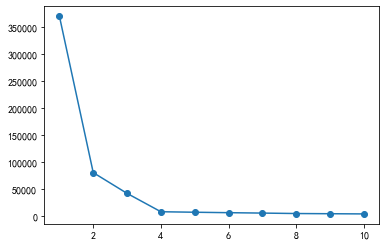

In [34]:
# 利用肘部法选择合适K值
inertia = []
for i in range(1,11):
    model = cluster.KMeans(n_clusters = i)
    model.fit(data1)
    inertia.append(model.inertia_)
plt.plot(range(1,11),inertia,'o-')   

In [35]:
# 可以看到k = 4最优，取k = 4聚类
model1 = cluster.KMeans(n_clusters = 4)
model1.fit(data1)
label = model1.labels_

In [36]:
# 将聚类结果写入数据集
data['label'] = label
data

<ipython-input-36-7282e039d920>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = label


,user_id,gender,age_range,Total_score,label
0,404724,2,3,44,2
1,247951,1,3,41,2
2,321246,1,3,14,1
3,364008,1,3,44,2
5,38706,1,2,22,3
...,...,...,...,...,...
3371,122718,1,3,22,3
3374,208823,1,2,33,0
3376,180510,1,4,23,3
3377,96992,2,2,21,3


<AxesSubplot:xlabel='col1', ylabel='col2'>

D:\Softwords\Python\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Softwords\Python\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


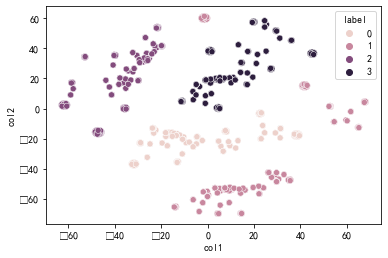

In [37]:
# 降维画图显示
tsne = manifold.TSNE() 
tsne_data = tsne.fit_transform(data1)
tsne_df = pd.DataFrame(tsne_data,columns=['col1','col2'])
tsne_df.loc[:,'label']=label
sns.scatterplot(x = 'col1',y='col2',hue='label',data=tsne_df)

## 轮廓系数评估聚类结果

In [38]:
score = metrics.silhouette_score(data1,label)
score # 轮廓系数取值为[-1, 1]，其值越大越好.0.78说明聚类效果很不错了。

0.784238783637643

# A/B Testing

有来了一个新问题：假如说现在淘宝要对landing page进行更新迭代，设计出了一个新的页面B，在推广前需要将**新的B页面**与**旧的A页面**之间进行A/B Testing，过程如下：
- **确定目标**：设置主要指标来衡量版本优劣，这里我们主要track指标"转化率（用户是否有过buy行为）"，"cilck次数"。
- **运行实验**：
    1. 用户分流：让两组**同质**，**均匀**的用户在**同一时间**(2015-12-13至2016-01-13期间)内分别体验两个不同的页面A与B。
    2. 收集实验数据：体验15天后收集两组用户的“转化率”以及“cilck次数”指标。（由于没有真实的数据，所以在这里我们在原数据的基础上增加一些扰动，随机生成实验结果数据）
    
- **假设检验**：对于“转化率”我们考虑使用z检验，对于“cilck次数”我们考虑使用t检验。

## 用户分流

截至目前，我们已经根据用户的"性别","年龄"，"RFM"这三个特征为用户增添了特征标签，将用户分成了风格迥异的四类。


由于landing page的变动是不确定性较强的实验，为了尽量减小用户体验影响，我们先使用小流量实验，如果实验中B页面表现的好，再考虑慢慢扩大实验范围。目前的分流比是让已有分类标签的2643个用户中的80%仍然使用旧的A页面（对照组），20%使用新的B页面（实验组）。

为了保证实验组与对照组用户的同质性，我们需要确保这两组用户的特征在各个维度都相似才可以。这时候我们之前聚类出来的用户标签就派上用场了！就像下方这个图所演示的，我们从类1、2、3、4中各取80%作为对照组用户，再从类1、2、3、4中各取20%作为实验组用户。

**由于每个类中的用户都是相似的，则抽出来的实验组与对照组也一定是相似的！**
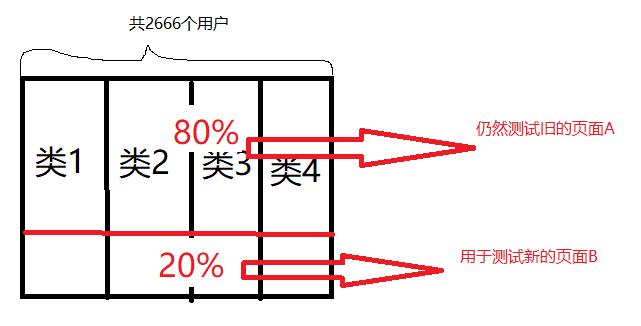

In [39]:
# 截至目前，我们已经对用户进行了分类
data_ab = data[['user_id','label']]
data_ab

,user_id,label
0,404724,2
1,247951,2
2,321246,1
3,364008,2
5,38706,3
...,...,...
3371,122718,3
3374,208823,0
3376,180510,3
3377,96992,3


In [40]:
# 在0组随机取20%的用户用于测试B页面，剩下的用户还是A页面
data_ab0 = data_ab[data_ab['label'] == 0]
# 将data_ab0打乱顺序
data_ab0 = data_ab0.reindex(np.random.permutation(data_ab0.index)).reset_index(drop = True) 
# 确定测试B页面的用户数量
n0 = int(data_ab0.shape[0] * 0.2)
# 更改label列为landing_page
data_ab0.iloc[0:n0,1] = 'B'
data_ab0.iloc[n0:,1] = 'A'
data_ab0.rename(columns = {'label':'landing_page'},inplace = True)
data_ab0

,user_id,landing_page
0,299921,B
1,78160,B
2,40042,B
3,398492,B
4,42328,B
...,...,...
640,366074,A
641,62120,A
642,189531,A
643,148654,A


In [41]:
# 在1组随机取20%的用户用于测试B页面，剩下的用户还是A页面
data_ab1 = data_ab[data_ab['label'] == 1]
# 将data_ab0打乱顺序
data_ab1 = data_ab1.reindex(np.random.permutation(data_ab1.index)).reset_index(drop = True) 
# 确定测试B页面的用户数量
n1 = int(data_ab1.shape[0] * 0.2)
# 更改label列为landing_page
data_ab1.iloc[0:n1,1] = 'B'
data_ab1.iloc[n1:,1] = 'A'
data_ab1.rename(columns = {'label':'landing_page'},inplace = True)
data_ab1

,user_id,landing_page
0,354676,B
1,204264,B
2,348996,B
3,338158,B
4,110297,B
...,...,...
692,279280,A
693,259463,A
694,97474,A
695,334227,A


In [42]:
# 在2组随机取20%的用户用于测试B页面，剩下的用户还是A页面
data_ab2 = data_ab[data_ab['label'] == 2]
# 将data_ab0打乱顺序
data_ab2 = data_ab2.reindex(np.random.permutation(data_ab2.index)).reset_index(drop = True) 
# 确定测试B页面的用户数量
n2 = int(data_ab2.shape[0] * 0.2)
# 更改label列为landing_page
data_ab2.iloc[0:n2,1] = 'B'
data_ab2.iloc[n2:,1] = 'A'
data_ab2.rename(columns = {'label':'landing_page'},inplace = True)
data_ab2

,user_id,landing_page
0,286647,B
1,183401,B
2,356914,B
3,228882,B
4,378202,B
...,...,...
648,423715,A
649,53384,A
650,315439,A
651,228520,A


In [43]:
# 在3组随机取20%的用户用于测试B页面，剩下的用户还是A页面
data_ab3 = data_ab[data_ab['label'] == 3]
# 将data_ab0打乱顺序
data_ab3 = data_ab3.reindex(np.random.permutation(data_ab3.index)).reset_index(drop = True) 
# 确定测试B页面的用户数量
n3 = int(data_ab3.shape[0] * 0.2)
# 更改label列为landing_page
data_ab3.iloc[0:n3,1] = 'B'
data_ab3.iloc[n3:,1] = 'A'
data_ab3.rename(columns = {'label':'landing_page'},inplace = True)
data_ab3

,user_id,landing_page
0,410671,B
1,108507,B
2,28545,B
3,223744,B
4,237806,B
...,...,...
677,321611,A
678,344609,A
679,217313,A
680,215882,A


In [44]:
# 将上面四个表，并按userid排列，并且重建索引
info_ab = pd.concat([data_ab0,data_ab1,data_ab2,data_ab3]).sort_values(by = 'user_id')
info_ab

,user_id,landing_page
105,36,B
297,217,A
472,285,A
327,598,A
260,799,A
...,...,...
22,423523,B
648,423715,A
537,423808,A
7,423876,B


## 生成实验数据

In [45]:
# 我们仅取2015-10-01至2015-11-01之前的数据（有意规避双11）
log7 = log3[(log3['time_stamp'] <= '2015-11-01') & (log3['time_stamp'] >= '2015-10-01')]
log7

,user_id,time_stamp,action_type
29658222,263940,2015-10-01,0
29658218,263940,2015-10-01,0
29658216,263940,2015-10-01,0
21412373,230809,2015-10-01,0
21412383,230809,2015-10-01,0
...,...,...,...
39178682,134610,2015-11-01,0
18987055,408380,2015-11-01,3
31352342,231753,2015-11-01,0
20214708,78306,2015-11-01,0


In [46]:
# 拆解表log7，将action_type列转行
log8 = pd.pivot_table(log7,
              index = 'user_id',# 以time_stamp为行索引分组
              columns = 'action_type',# 根据action_type的不同分割每行的数据
              
              aggfunc = np.size 
              )
log8.columns = ["click","cart",'buy','fav']
log8

,click,cart,buy,fav
user_id,,,,
36,9.0,NaN,NaN,NaN
217,16.0,NaN,NaN,1.0
285,3.0,NaN,1.0,NaN
467,2.0,NaN,NaN,NaN
538,NaN,1.0,NaN,NaN
...,...,...,...,...
423523,124.0,NaN,10.0,2.0
423715,3.0,NaN,NaN,NaN
423876,55.0,NaN,3.0,NaN


In [47]:
# 首先删除掉都是NAN的行
log8.dropna(how = 'all')
# 可以看到没有都是NaN的行

,click,cart,buy,fav
user_id,,,,
36,9.0,NaN,NaN,NaN
217,16.0,NaN,NaN,1.0
285,3.0,NaN,1.0,NaN
467,2.0,NaN,NaN,NaN
538,NaN,1.0,NaN,NaN
...,...,...,...,...
423523,124.0,NaN,10.0,2.0
423715,3.0,NaN,NaN,NaN
423876,55.0,NaN,3.0,NaN


In [48]:
print(log8['click'].isnull().sum())
print(log8['cart'].isnull().sum())
print(log8['buy'].isnull().sum())
print(log8['fav'].isnull().sum())
# 'cart'和'fav'列的缺失值比较多，所以我们只考虑buy与cilck
# buy有1713行缺失：说明这1713个用户在2015-10-01至2015-11-01期间没有购买行为。
# cilck有142行缺失，前面知道了没有都是NaN的行，说明这142行是脏数据（有cart，buy，fav行为就不可能没有cilck行为），需要去掉。

138
3425
1744
2321


In [49]:
log9 = log8[log8['click'].notnull()][['click','buy']] #去掉cilck的42行缺失的脏数据
# 我们不考虑购买次数，只考虑是否有购买行为(将buy转换为0,1)
log9['buy'] = log9['buy'].map(lambda x: 0 if np.isnan(x) else 1)
# 转换click数据类型为int型
log9['click'] = log9['click'].map(lambda x: int(x))
log9

,click,buy
user_id,,
36,9,0
217,16,0
285,3,1
467,2,0
598,6,1
...,...,...
423523,124,1
423715,3,0
423876,55,1


In [50]:
#将log9与info_ab连接
ab = pd.merge(info_ab,log9,right_index = True,left_on = 'user_id')[['user_id','click','buy','landing_page']].reset_index(drop = True)
ab

,user_id,click,buy,landing_page
0,36,9,0,B
1,217,16,0,A
2,285,3,1,A
3,598,6,1,A
4,799,25,1,A
...,...,...,...,...
2224,423225,37,1,A
2225,423523,124,1,B
2226,423715,3,0,A
2227,423876,55,1,B


至此，我们得到了测试A页面与测试B页面的用户数据。但是这个数据其实不是我们实验期间（2015-12-13至2016-01-13期间）得到的数据，而是根据原始数据（2015-10-01至2015-11-01期间）用户使用旧的页面A得到的数据。真正的实验数据我无法获得，所以我依据原始数据随机生成

- 根据landing_page = 'A'的用户的'click'的均值生成一列正态分布的数据。我们把他当作测试A页面的用户在实验期间的'click'数据；根据landing_page = 'A'的用户的购买率生成一列是否购买的数据，记入**表A**。

- 而表B的数据却不能再用ab表中只有landing_page = 'B'的数据了（因为landing_page = 'B'的用户行为数据也是他们浏览页面A所得到是数据）。所以我们在原始数据的基础上加一些扰动，形成新的B页面的实验数据，计入**表B**。

In [51]:
# 生成测试页面A的用户行为数据
a_mean = ab[ab['landing_page'] == 'A']['click'].mean()
a_n = ab[ab['landing_page'] == 'A'].shape[0]
a_click = pd.Series(np.random.normal(a_mean,8, size=a_n)).apply(lambda x: int(x))
a_buy = ab[ab['landing_page'] == 'A']['buy'].reset_index(drop = True)
A = pd.concat([a_click,a_buy],axis = 1)
A = A.rename(columns = {0:'click'})
A

,click,buy
0,38,0
1,24,1
2,24,1
3,30,1
4,8,1
...,...,...
1762,26,1
1763,26,0
1764,44,1
1765,30,0


In [52]:
# 生成测试页面B的用户行为数据
b_mean = ab[ab['landing_page'] == 'A']['click'].mean() + 6#令页面B的点击数量均值比页面A稍微高一点
b_n = ab[ab['landing_page'] == 'B'].shape[0]
b_click = pd.Series(np.random.normal(b_mean,8,size=b_n)).apply(lambda x: int(x))

convert_b = (A['buy'].sum() / A['buy'].shape[0] ) * 1.1 #令页面B的转化率比页面A稍微高一点
zero = pd.Series(np.zeros(b_n)).apply(lambda x: int(x))
index_b = zero.sample(frac = convert_b).index
zero.iloc[index_b] = 1

B = pd.concat([b_click,zero],axis = 1)
B = B.rename(columns = {0:'click',1:'buy'})
B

,click,buy
0,33,1
1,44,1
2,36,1
3,34,0
4,37,1
...,...,...
457,37,1
458,33,1
459,33,1
460,30,1


## 假设检验

### 两页面用户“转化率”之间的检验

#### z检验

这里的“转化率”就是购买率。

作N次独立重复试验，以x记事件(有购买行为)发生的次数，则x服从二项分布$b(n,p)$。两个总体比率$p_1$与$p_2$之间的检验可以用$z$检验。

- 设一个用户浏览页面**A**发生购买行为的概率为$p_1$,记$x_1$为1755个用户中有购买行为的用户的数量，则$x_1$服从二项分布$b(1755,p1)$
- 设一个用户浏览页面**B**发生购买行为的概率为$p_2$,记$x_2$为435个用户中有购买行为的用户的数量，则$x_2$服从二项分布$b(435,p2)$

下面做出假设$$H_0: p_1 - p_2 >= 0$$ $$H_1: p_1 - p_2 < 0 $$

则拒绝域为$W = \{z < z_\alpha\}$,取$\alpha = 0.05$

In [53]:
# 先计算出p1与p2
p1 = A['buy'].sum() / A['buy'].shape[0]
p2 = B['buy'].sum() / B['buy'].shape[0]

In [54]:
# 再计算检验统计量z
z = (p1 - p2) / np.sqrt((p1* (1-p1) / a_n)+(p2 * (1-p2) / b_n))
z

-2.4183696074356016

In [55]:
# 查找正态分布的0.05分位数
z_alpha = norm.ppf(0.05)
z_alpha

-1.6448536269514729

则拒绝域为$W = \{z < -1.64\}$,检验统计量$z = -2.41$落入拒绝域，则拒绝原假设，即我们认为B页面的用户转化率是高于A页面的。

用p值法再解一遍：

In [56]:
import statsmodels.stats.proportion as sp

In [57]:
sp.proportions_ztest([A[A['buy'] == 1].shape[0],B[B['buy'] == 1].shape[0]],[a_n,b_n],alternative = 'smaller')

(-2.3680456171703765, 0.008941165451123612)

同样用p值法，利用python自带的包求得$p = 0.01 < \alpha$，也会得出拒绝原假设的结论。

#### 计算效应量（科恩D值）

效应量是用于判断研究的结果是否有意义。效应量太小，意味着处理即使达到了显著水平，也缺乏实用价值。

In [58]:
std1 = A['buy'].std()
std2 = B['buy'].std()
n1 = A.shape[0]
n2 = B.shape[0]
s = np.sqrt(    ((n1-1) * std1 ** 2   +      (n2-1) *std2 ** 2    )    /     (n1+n2-2))
d = (p1 - p2) / s
d

-0.12383912932220163

### 两页面用户“点击量”均值检验

首先考虑两正态总体均值的t检验。

我们现在已经有了两页面的两条样本序列了，t检验可以检验处两个独立样本所代表的总体均值的差异是否显著。

要进行t检验，有如下条件：
- 两样本均来自正态总体
- 两总体方差相等


下面我们逐一判断。

#### 条件1：正态性检验

D:\Softwords\Python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Softwords\Python\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='click', ylabel='Density'>

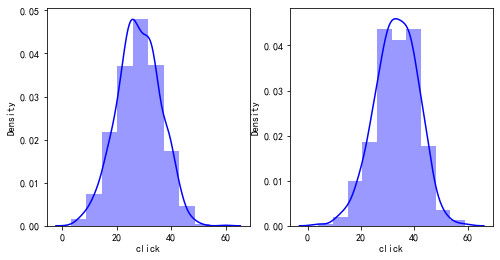

In [59]:
# 先画个图看看
fig,axes = plt.subplots(nrows = 1,ncols = 2,figsize = (8,4))
sns.distplot(A['click'], color='b', bins=10, kde=True,ax = axes[0])
sns.distplot(B['click'], color='b', bins=10, kde=True,ax = axes[1])
# 应该是正态分布了

In [169]:
# 保险起见，再检验一下
print(stats.normaltest(A['click']))
print(stats.normaltest(B['click']))
#p都远大于0.05，可以十分肯定的认为数据来源于正态分布了！

NormaltestResult(statistic=2.140346313210169, pvalue=0.3429491283702668)
NormaltestResult(statistic=4.227998494276426, pvalue=0.12075407409056058)


#### 条件2：方差齐性检验

“方差齐性检验”就是检验两个样本各自所代表的正态总体的方差的差异是否显著。

In [170]:
stats.levene(A['click'],B['click'])
# p = 0.9> 0.05,满足方差齐性

LeveneResult(statistic=0.0038118890892118724, pvalue=0.9507750290150789)

#### 终于可以进行t检验了！

设$X_1$，$X_2$分别表示用户浏览页面A的总点击量以及浏览页面B的总点击量。由前面的正态性检验与方差齐性检验，我们可以说：

<center>$X_1\sim N(\mu_1,\sigma_1^2)$，$X_2\sim N(\mu_2,\sigma_2^2)$.其中$\sigma_1^2 = \sigma_2^2$.<center>
    
现在我们要利用t检验，根据已有的样本序列，检验是否$\mu_2 > \mu_1$

下面做出假设:$$H_1:\mu_1 <= \mu_2$$ $$H_0: \mu_1 > \mu_2$$

则拒绝域为$W = \{t >= t_1-\alpha(m+n-2)\}$,取$\alpha = 0.05$

In [171]:
# 计算检验统计量t
m1 = A['click'].mean()
m2 = B['click'].mean()
sw = np.sqrt((((A['click'] - m1)**2).sum() + ((B['click'] - m2)**2).sum()) / (1 / (A['click'].shape[0] + B['click'].shape[0] -2)))
t = (m1 - m2) / (sw * (np.sqrt((1/A['click'].shape[0])+(1/B['click'].shape[0]))))
t

-0.005633080744860849

In [172]:
# 查找正态分布的0.05分位数
t_alpha = stats.t.ppf(0.95,A['click'].shape[0] + B['click'].shape[0]-2)
t_alpha

1.6455381384315175

则拒绝域为$W = \{t >= 1.65\}$,检验统计量$t = -0.0056$没有落入拒绝域，接受原假设，即我们认为B页面的平均点击量是高于A页面的。

#### 计算效应量（科恩D值）

In [173]:
mean1 = A['click'].mean()
mean2 = B['click'].mean()
std1 = A['click'].std()
std2 = B['click'].std()
n1 = A.shape[0]
n2 = B.shape[0]
s = np.sqrt(    ((n1-1) * std1 ** 2   +      (n2-1) *std2 ** 2    )    /     (n1+n2-2))
d = (mean1 - mean2) / s
d

-0.6555139905586295

## A/B Testing 报告

**结论：**

本次A/B Testing共track了两个指标，“转化率”与“点击量”，来判断B页面的用户转化表现。

1. 对于A页面与B页面的用户“转化率”之间的比较我们采取了z检验，得到的结论如下：

    - 检验统计量 $𝑧 = -2.418$ 落入拒绝域，则拒绝原假设，即我们认为B页面的用户转化率是高于A页面的。
    - 但值得注意的是，科恩D值 = -0.123过小，我们关于“转化率”的假设检验缺乏使用价值。
    
2. 对于A页面与B页面的用户“点击量”之间的比较我们采取了t检验，得到的结论如下：
    - 检验统计量$t = −0.0056$没有落入拒绝域，接受原假设，即我们认为B页面的平均点击量是高于A页面的。
    - 但值得注意的是，科恩D值 = -0.655过小，我们关于“点击量”的假设检验缺乏使用价值。
    
**建议：**

B页面无论是在用户“转化率”还是在“点击率”上都优于A页面。说明B页面对用户更具有吸引力，并且更有利于促成用户的购买行为。因此可以考虑继续扩大B页面的实验范围。